Dataset period:
Start: 2021-01-01 00:00:00
End: 2022-02-28 00:00:00
Number of observations: 424

Descriptive statistics:
        return_1d  sentiment_news_z  sentiment_twitter_z
count  424.000000      4.240000e+02         4.240000e+02
mean     0.001807     -8.379042e-17        -3.351617e-17
std      0.041691      1.000000e+00         1.000000e+00
min     -0.143751     -4.370548e+00        -3.670616e+00
25%     -0.021090     -6.051155e-01        -6.188948e-01
50%      0.000260      3.957307e-02         1.363646e-01
75%      0.023980      5.953353e-01         6.782673e-01
max      0.195361      2.802063e+00         3.023432e+00

1. CONTEMPORANEOUS CORRELATIONS:

Pearson correlation matrix:
                     return_1d  sentiment_news_z  sentiment_twitter_z
return_1d             1.000000         -0.072709             0.299438
sentiment_news_z     -0.072709          1.000000             0.048640
sentiment_twitter_z   0.299438          0.048640             1.000000

Spearman correlation m

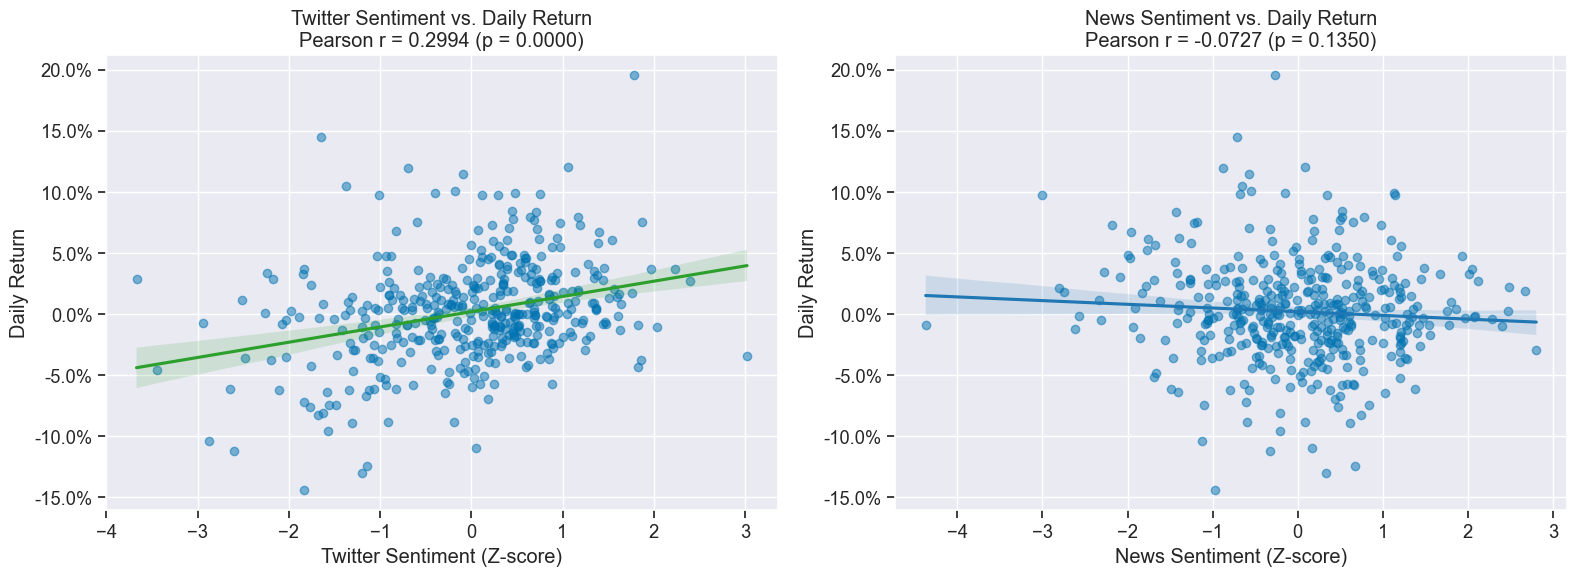

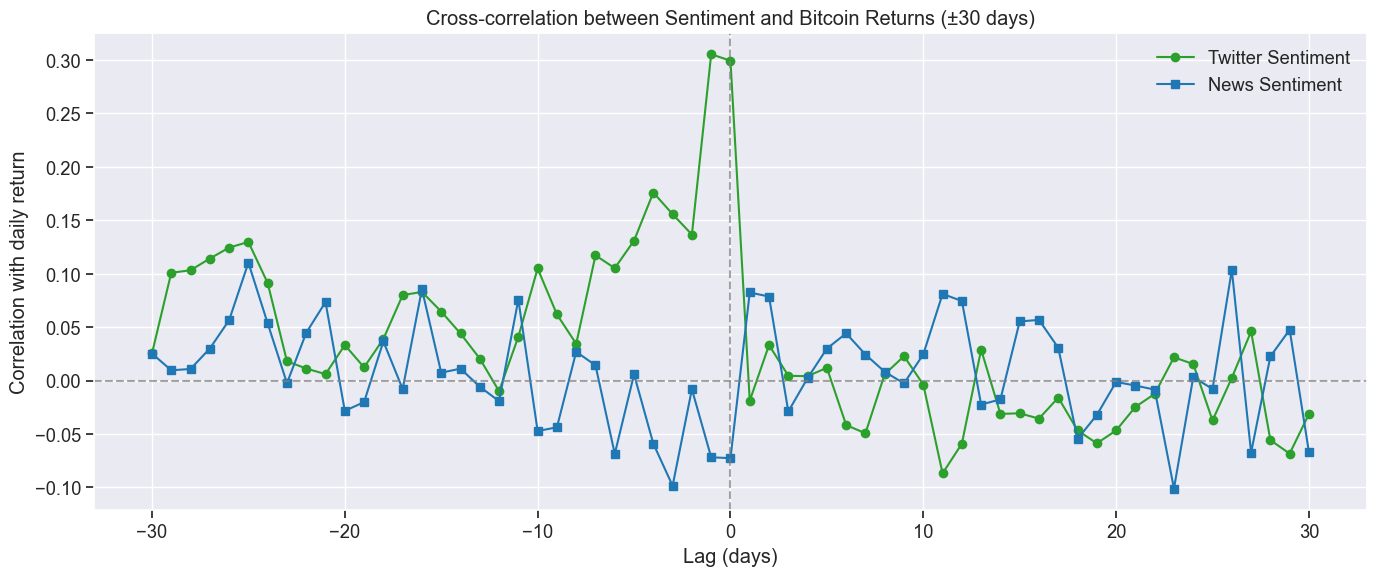

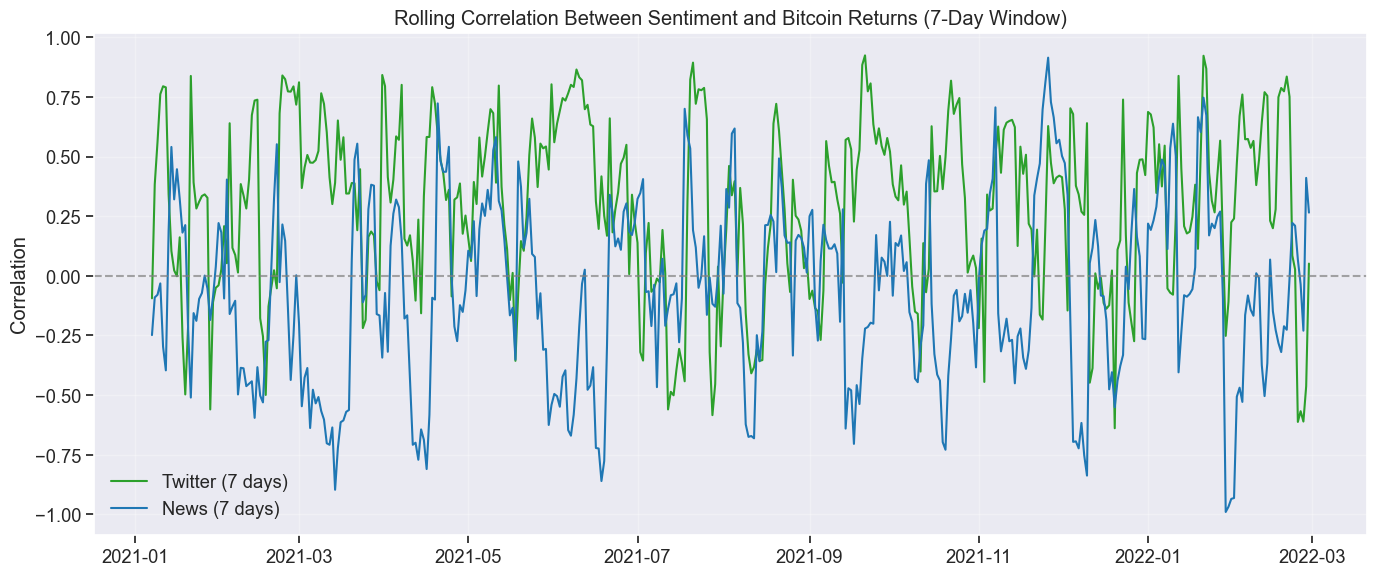

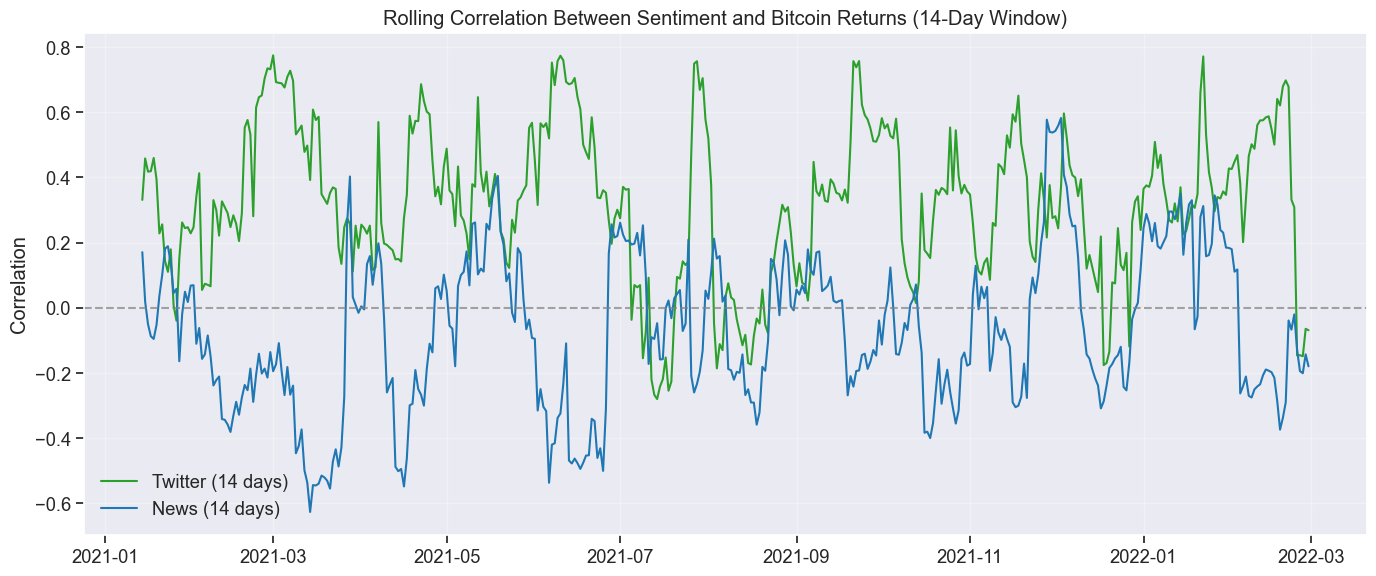

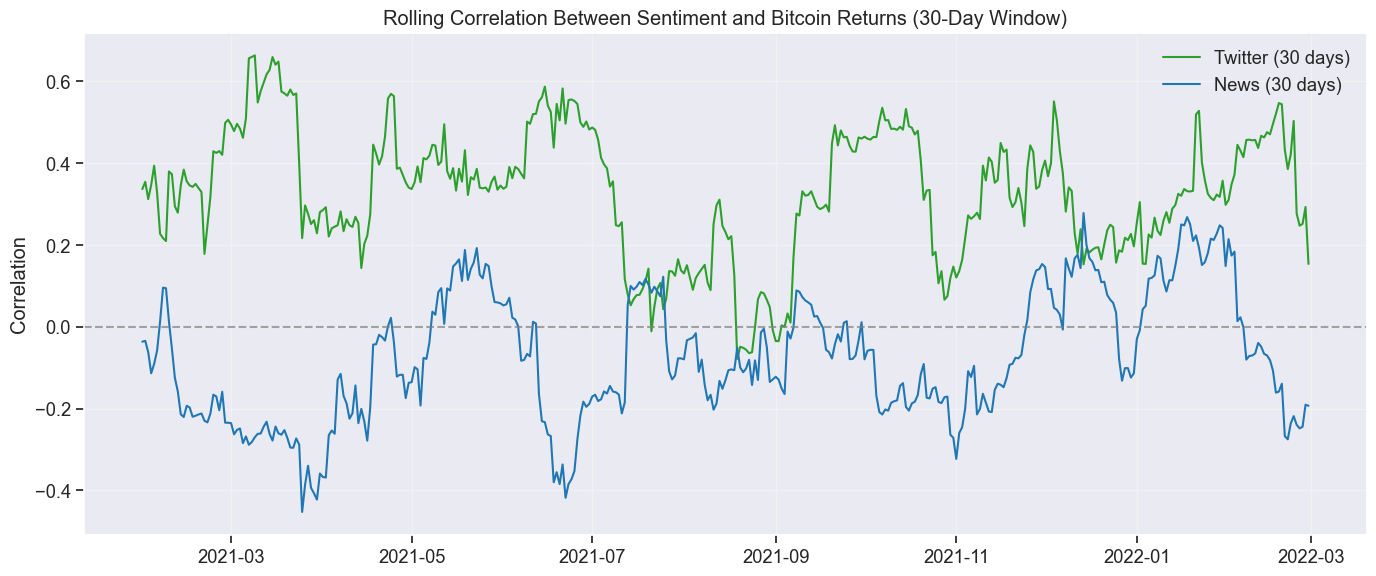

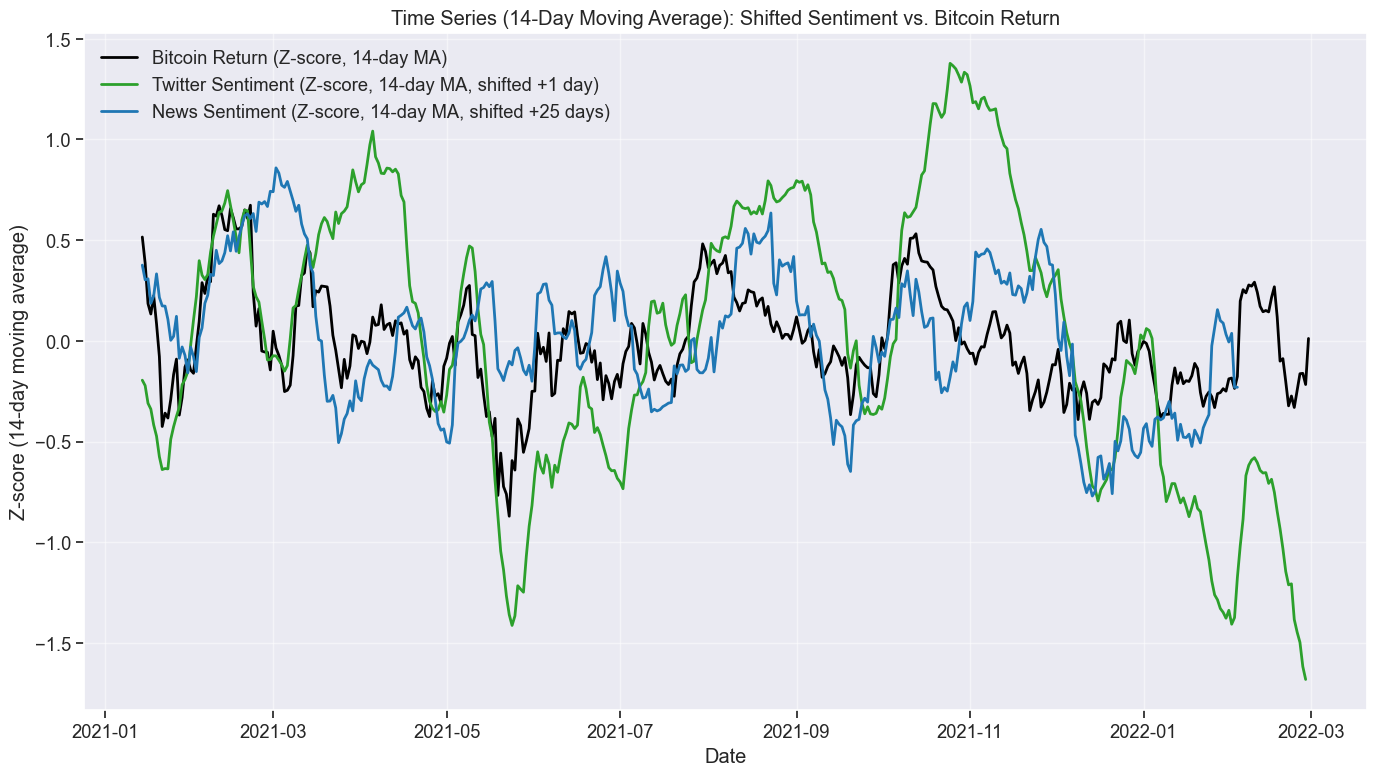

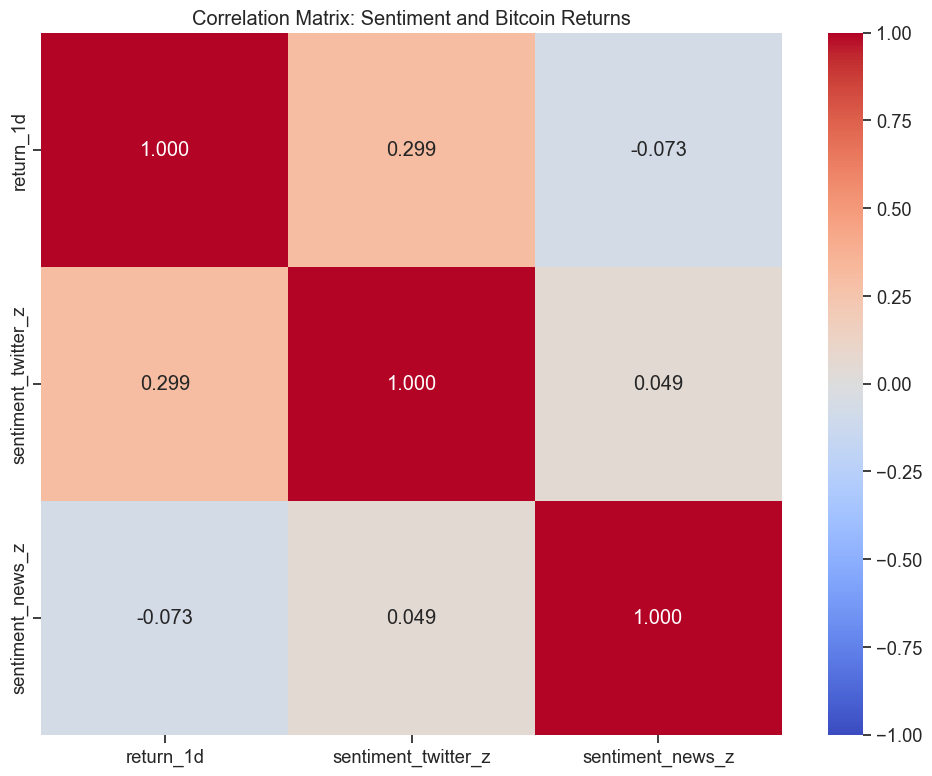

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import warnings

# Disable warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
pd.options.mode.chained_assignment = None

# Style settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("colorblind")
sns.set_context("notebook", font_scale=1.2)

colors = {
    'news': '#1f77b4',
    'twitter': '#2ca02c',
    'highlight': '#d62728',
}

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['figure.figsize'] = (12, 8)

# Function to calculate rolling correlation
def rolling_correlation(x, y, window):
    return pd.Series(x).rolling(window=window).corr(pd.Series(y))

# Load data
df = pd.read_csv(r"C:\Users\Kasper Hassing\Desktop\Speciale_KryptoSentiment\data\market_data\BTCUSDT_features_final_sentiment.csv")

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
df.sort_index(inplace=True)

# Drop rows with missing values
df = df.dropna(subset=['return_1d', 'sentiment_news_z', 'sentiment_twitter_z'])

print("Dataset period:")
print(f"Start: {df.index.min()}")
print(f"End: {df.index.max()}")
print(f"Number of observations: {len(df)}")

# Select relevant columns
data = df[['return_1d', 'sentiment_news_z', 'sentiment_twitter_z']]

print("\nDescriptive statistics:")
print(data.describe())

# 1. CONTEMPORANEOUS CORRELATIONS
print("\n1. CONTEMPORANEOUS CORRELATIONS:")

# Pearson correlation
pearson_corr = data.corr(method='pearson')
print("\nPearson correlation matrix:")
print(pearson_corr)

# Spearman correlation
spearman_corr = data.corr(method='spearman')
print("\nSpearman correlation matrix:")
print(spearman_corr)

# Statistical significance (Pearson)
twitter_pearson, twitter_p_value = pearsonr(data['sentiment_twitter_z'], data['return_1d'])
news_pearson, news_p_value = pearsonr(data['sentiment_news_z'], data['return_1d'])

print("\nStatistical significance (Pearson):")
print(f"Twitter vs. Return: r = {twitter_pearson:.4f}, p = {twitter_p_value:.4f}")
print(f"News vs. Return: r = {news_pearson:.4f}, p = {news_p_value:.4f}")

# Statistical significance (Spearman)
twitter_spearman, twitter_spearman_p = spearmanr(data['sentiment_twitter_z'], data['return_1d'])
news_spearman, news_spearman_p = spearmanr(data['sentiment_news_z'], data['return_1d'])

print("\nStatistical significance (Spearman):")
print(f"Twitter vs. Return: rho = {twitter_spearman:.4f}, p = {twitter_spearman_p:.4f}")
print(f"News vs. Return: rho = {news_spearman:.4f}, p = {news_spearman_p:.4f}")

# Scatter plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

def percentage_formatter(x, pos):
    return f'{100 * x:.1f}%'

# Twitter
sns.regplot(x='sentiment_twitter_z', y='return_1d', data=data, ax=axes[0], scatter_kws={'alpha':0.5}, line_kws={'color':colors['twitter']})
axes[0].set_title(f'Twitter Sentiment vs. Daily Return\nPearson r = {twitter_pearson:.4f} (p = {twitter_p_value:.4f})')
axes[0].set_xlabel('Twitter Sentiment (Z-score)')
axes[0].set_ylabel('Daily Return')
axes[0].yaxis.set_major_formatter(FuncFormatter(percentage_formatter))

# News
sns.regplot(x='sentiment_news_z', y='return_1d', data=data, ax=axes[1], scatter_kws={'alpha':0.5}, line_kws={'color':colors['news']})
axes[1].set_title(f'News Sentiment vs. Daily Return\nPearson r = {news_pearson:.4f} (p = {news_p_value:.4f})')
axes[1].set_xlabel('News Sentiment (Z-score)')
axes[1].set_ylabel('Daily Return')
axes[1].yaxis.set_major_formatter(FuncFormatter(percentage_formatter))

plt.tight_layout()
plt.savefig('scatter_sentiment_return.png', dpi=300, bbox_inches='tight')

# 2. LAG ANALYSIS (LEAD/LAG)
print("\n2. LAG ANALYSIS (LEAD/LAG):")

# Create shifted variables
for lag in [1, 3]:
    data.loc[:, f'twitter_lead_{lag}d'] = data['sentiment_twitter_z'].shift(lag)
    data.loc[:, f'news_lead_{lag}d'] = data['sentiment_news_z'].shift(lag)
    data.loc[:, f'twitter_lag_{lag}d'] = data['sentiment_twitter_z'].shift(-lag)
    data.loc[:, f'news_lag_{lag}d'] = data['sentiment_news_z'].shift(-lag)

lag_data = data.dropna()

lead_corrs = pd.DataFrame({
    'Twitter_lead_1d': [pearsonr(lag_data['twitter_lead_1d'], lag_data['return_1d'])[0],
                        pearsonr(lag_data['twitter_lead_1d'], lag_data['return_1d'])[1]],
    'News_lead_1d': [pearsonr(lag_data['news_lead_1d'], lag_data['return_1d'])[0],
                     pearsonr(lag_data['news_lead_1d'], lag_data['return_1d'])[1]],
    'Twitter_lead_3d': [pearsonr(lag_data['twitter_lead_3d'], lag_data['return_1d'])[0],
                        pearsonr(lag_data['twitter_lead_3d'], lag_data['return_1d'])[1]],
    'News_lead_3d': [pearsonr(lag_data['news_lead_3d'], lag_data['return_1d'])[0],
                     pearsonr(lag_data['news_lead_3d'], lag_data['return_1d'])[1]]
}, index=['Pearson r', 'p-value'])

lag_corrs = pd.DataFrame({
    'Twitter_lag_1d': [pearsonr(lag_data['return_1d'], lag_data['twitter_lag_1d'])[0],
                       pearsonr(lag_data['return_1d'], lag_data['twitter_lag_1d'])[1]],
    'News_lag_1d': [pearsonr(lag_data['return_1d'], lag_data['news_lag_1d'])[0],
                    pearsonr(lag_data['return_1d'], lag_data['news_lag_1d'])[1]],
    'Twitter_lag_3d': [pearsonr(lag_data['return_1d'], lag_data['twitter_lag_3d'])[0],
                       pearsonr(lag_data['return_1d'], lag_data['twitter_lag_3d'])[1]],
    'News_lag_3d': [pearsonr(lag_data['return_1d'], lag_data['news_lag_3d'])[0],
                    pearsonr(lag_data['return_1d'], lag_data['news_lag_3d'])[1]]
}, index=['Pearson r', 'p-value'])

print("\nSentiment leads return:")
print(lead_corrs)

print("\nReturn leads sentiment:")
print(lag_corrs)

# 2b. CROSS-CORRELATION
max_lag = 30
lags = range(-max_lag, max_lag + 1)
twitter_ccf, news_ccf = [], []

for lag in lags:
    if lag >= 0:
        twitter_shift = data['sentiment_twitter_z'].shift(lag)
        news_shift = data['sentiment_news_z'].shift(lag)
        mask_twitter = ~twitter_shift.isna()
        mask_news = ~news_shift.isna()
        twitter_ccf.append(pearsonr(twitter_shift[mask_twitter], data['return_1d'][mask_twitter])[0])
        news_ccf.append(pearsonr(news_shift[mask_news], data['return_1d'][mask_news])[0])
    else:
        return_shift = data['return_1d'].shift(-lag)
        mask_twitter = ~data['sentiment_twitter_z'].isna() & ~return_shift.isna()
        mask_news = ~data['sentiment_news_z'].isna() & ~return_shift.isna()
        twitter_ccf.append(pearsonr(data['sentiment_twitter_z'][mask_twitter], return_shift[mask_twitter])[0])
        news_ccf.append(pearsonr(data['sentiment_news_z'][mask_news], return_shift[mask_news])[0])

plt.figure(figsize=(14, 6))
plt.plot(lags, twitter_ccf, marker='o', label='Twitter Sentiment', color=colors['twitter'])
plt.plot(lags, news_ccf, marker='s', label='News Sentiment', color=colors['news'])
plt.axvline(x=0, linestyle='--', color='gray', alpha=0.7)
plt.axhline(y=0, linestyle='--', color='gray', alpha=0.7)
plt.xlabel('Lag (days)')
plt.ylabel('Correlation with daily return')
plt.legend()
plt.title('Cross-correlation between Sentiment and Bitcoin Returns (±30 days)')
plt.tight_layout()
plt.savefig('cross_correlation_sentiment.png', dpi=300)

print("\nLag with strongest correlation:")
print(f"Twitter Sentiment: {lags[np.argmax(np.abs(twitter_ccf))]} days, corr = {max(twitter_ccf, key=abs):.4f}")
print(f"News Sentiment: {lags[np.argmax(np.abs(news_ccf))]} days, corr = {max(news_ccf, key=abs):.4f}")

# 3. GRANGER CAUSALITY
print("\n3. GRANGER CAUSALITY TEST:")

granger_data = data[['return_1d', 'sentiment_twitter_z', 'sentiment_news_z']].copy().fillna(method='ffill').dropna()
maxlag = 5

twitter_to_return = grangercausalitytests(granger_data[['sentiment_twitter_z', 'return_1d']], maxlag=maxlag, verbose=False)
news_to_return = grangercausalitytests(granger_data[['sentiment_news_z', 'return_1d']], maxlag=maxlag, verbose=False)
return_to_twitter = grangercausalitytests(granger_data[['return_1d', 'sentiment_twitter_z']], maxlag=maxlag, verbose=False)
return_to_news = grangercausalitytests(granger_data[['return_1d', 'sentiment_news_z']], maxlag=maxlag, verbose=False)

granger_results = pd.DataFrame(index=['Twitter → Return', 'News → Return', 'Return → Twitter', 'Return → News'],
    columns=pd.MultiIndex.from_product([range(1, maxlag + 1), ['F-stat', 'p-value']]))

for lag in range(1, maxlag + 1):
    granger_results.loc['Twitter → Return', (lag, 'F-stat')] = twitter_to_return[lag][0]['ssr_ftest'][0]
    granger_results.loc['Twitter → Return', (lag, 'p-value')] = twitter_to_return[lag][0]['ssr_ftest'][1]
    granger_results.loc['News → Return', (lag, 'F-stat')] = news_to_return[lag][0]['ssr_ftest'][0]
    granger_results.loc['News → Return', (lag, 'p-value')] = news_to_return[lag][0]['ssr_ftest'][1]
    granger_results.loc['Return → Twitter', (lag, 'F-stat')] = return_to_twitter[lag][0]['ssr_ftest'][0]
    granger_results.loc['Return → Twitter', (lag, 'p-value')] = return_to_twitter[lag][0]['ssr_ftest'][1]
    granger_results.loc['Return → News', (lag, 'F-stat')] = return_to_news[lag][0]['ssr_ftest'][0]
    granger_results.loc['Return → News', (lag, 'p-value')] = return_to_news[lag][0]['ssr_ftest'][1]

print("\nGranger causality test results:")
print(granger_results)

print("\nSignificant Granger results (p < 0.05):")
for idx in granger_results.index:
    for lag in range(1, maxlag + 1):
        if granger_results.loc[idx, (lag, 'p-value')] < 0.05:
            print(f"{idx} at lag {lag}: F = {granger_results.loc[idx, (lag, 'F-stat')]:.4f}, p = {granger_results.loc[idx, (lag, 'p-value')]:.4f}")

# 4. OLS REGRESSION
print("\n4. OLS REGRESSION:")

reg_data = data.copy()
reg_data['sentiment_twitter_lag0'] = reg_data['sentiment_twitter_z']
reg_data['sentiment_twitter_lag1'] = reg_data['sentiment_twitter_z'].shift(1)
reg_data['sentiment_twitter_lag3'] = reg_data['sentiment_twitter_z'].shift(3)
reg_data['sentiment_news_lag0'] = reg_data['sentiment_news_z']
reg_data['sentiment_news_lag1'] = reg_data['sentiment_news_z'].shift(1)
reg_data['sentiment_news_lag3'] = reg_data['sentiment_news_z'].shift(3)
reg_data = reg_data.dropna()

# Twitter regression
X_twitter = reg_data[['sentiment_twitter_lag0', 'sentiment_twitter_lag1', 'sentiment_twitter_lag3']]
X_twitter = sm.add_constant(X_twitter)
y = reg_data['return_1d']
model_twitter = sm.OLS(y, X_twitter).fit()
print("\nTwitter sentiment regression:")
print(model_twitter.summary())

# News regression
X_news = reg_data[['sentiment_news_lag0', 'sentiment_news_lag1', 'sentiment_news_lag3']]
X_news = sm.add_constant(X_news)
model_news = sm.OLS(y, X_news).fit()
print("\nNews sentiment regression:")
print(model_news.summary())

# Combined model
X_combined = reg_data[['sentiment_twitter_lag0', 'sentiment_twitter_lag1', 'sentiment_twitter_lag3',
                       'sentiment_news_lag0', 'sentiment_news_lag1', 'sentiment_news_lag3']]
X_combined = sm.add_constant(X_combined)
model_combined = sm.OLS(y, X_combined).fit()
print("\nCombined sentiment regression:")
print(model_combined.summary())

# Economic interpretation
twitter_effect_pct = model_twitter.params['sentiment_twitter_lag1'] * 100
news_effect_pct = model_news.params['sentiment_news_lag1'] * 100

print("\nEconomic interpretation:")
print(f"A 1 standard deviation increase in Twitter sentiment (lag 1) is associated with a {twitter_effect_pct:.4f}% change in daily return.")
print(f"A 1 standard deviation increase in news sentiment (lag 1) is associated with a {news_effect_pct:.4f}% change in daily return.")

# 5. ROLLING CORRELATION ANALYSIS
print("\n5. ROLLING CORRELATION ANALYSIS:")

windows = [7, 14, 30]
rolling_corrs = {}

for window in windows:
    rolling_corrs[f'twitter_{window}d'] = rolling_correlation(data['sentiment_twitter_z'], data['return_1d'], window)
    rolling_corrs[f'news_{window}d'] = rolling_correlation(data['sentiment_news_z'], data['return_1d'], window)

for window in windows:
    plt.figure(figsize=(14, 6))
    plt.plot(rolling_corrs[f'twitter_{window}d'].index, rolling_corrs[f'twitter_{window}d'], 
             label=f'Twitter ({window} days)', color=colors['twitter'])
    plt.plot(rolling_corrs[f'news_{window}d'].index, rolling_corrs[f'news_{window}d'], 
             label=f'News ({window} days)', color=colors['news'])
    plt.axhline(y=0, linestyle='--', color='gray', alpha=0.7)
    plt.legend()
    plt.title(f'Rolling Correlation Between Sentiment and Bitcoin Returns ({window}-Day Window)')
    plt.ylabel('Correlation')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'rolling_correlation_{window}d.png', dpi=300)

print("\nRolling correlation summary stats:")
for window in windows:
    print(f"\n{window}-day window:")
    print(f"Twitter: Mean = {rolling_corrs[f'twitter_{window}d'].mean():.4f}, Std = {rolling_corrs[f'twitter_{window}d'].std():.4f}")
    print(f"News: Mean = {rolling_corrs[f'news_{window}d'].mean():.4f}, Std = {rolling_corrs[f'news_{window}d'].std():.4f}")
    twitter_pos = (rolling_corrs[f'twitter_{window}d'] > 0).mean()
    news_pos = (rolling_corrs[f'news_{window}d'] > 0).mean()
    print(f"Twitter: Positive correlation {twitter_pos*100:.1f}% of the time")
    print(f"News: Positive correlation {news_pos*100:.1f}% of the time")

# 6. TIME SERIES PLOT WITH SHIFTED AND SMOOTHED SENTIMENT
best_twitter_lag = np.argmax(np.abs(twitter_ccf)) - max_lag
best_news_lag = np.argmax(np.abs(news_ccf)) - max_lag

# Standardize and smooth return
smooth_window = 14
data['return_1d_z'] = (data['return_1d'] - data['return_1d'].mean()) / data['return_1d'].std()
data['return_1d_z_smooth'] = data['return_1d_z'].rolling(smooth_window).mean()

# Shift and smooth sentiment
twitter_shifted_smooth = data['sentiment_twitter_z'].shift(best_twitter_lag).rolling(smooth_window).mean()
news_shifted_smooth = data['sentiment_news_z'].shift(best_news_lag).rolling(smooth_window).mean()

# Plot
plt.figure(figsize=(14, 8))

# Plot with enhanced labels and line thickness
plt.plot(data.index, data['return_1d_z_smooth'],
         label='Bitcoin Return (Z-score, 14-day MA)', color='black', linewidth=2)

twitter_label = f'Twitter Sentiment (Z-score, 14-day MA, shifted +{abs(best_twitter_lag)} day{"s" if abs(best_twitter_lag) != 1 else ""})'
plt.plot(data.index, twitter_shifted_smooth,
         label=twitter_label, color=colors['twitter'], linewidth=2)

news_label = f'News Sentiment (Z-score, 14-day MA, shifted +{abs(best_news_lag)} day{"s" if abs(best_news_lag) != 1 else ""})'
plt.plot(data.index, news_shifted_smooth,
         label=news_label, color=colors['news'], linewidth=2)

# Labels and formatting
plt.title('Time Series (14-Day Moving Average): Shifted Sentiment vs. Bitcoin Return')
plt.xlabel('Date')
plt.ylabel('Z-score (14-day moving average)')
plt.legend()
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.savefig('timeseries_shifted_sentiment_moving_average.png', dpi=300)


# Final Summary Table
correlation_table = pd.DataFrame({
    'Pearson_r': [twitter_pearson, news_pearson],
    'Pearson_p': [twitter_p_value, news_p_value],
    'Spearman_rho': [twitter_spearman, news_spearman],
    'Spearman_p': [twitter_spearman_p, news_spearman_p]
}, index=['Twitter', 'News'])

print("\nFinal correlation summary:")
print(correlation_table)

# Save results
correlation_table.to_csv('correlation_results.csv')
granger_results.to_csv('granger_results.csv')

# Heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = data[['return_1d', 'sentiment_twitter_z', 'sentiment_news_z']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, fmt='.3f')
plt.title('Correlation Matrix: Sentiment and Bitcoin Returns')
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300)

print("\nAll analyses completed. Figures and results saved.")
